In [1]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM, Net, ReCAM    
from misc import imutils
import matplotlib.pyplot as plt
from tqdm import tqdm

from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion
from chainercv.evaluations import calc_semantic_segmentation_iou


CAT_LIST = ['aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train',
            'tvmonitor']

plt.rcParams.update({"text.usetex": True})

cam_eval_thres = 0.16
chainer_eval_set = 'train'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
cam_out_dir = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/C2AM'
cam_out_dir_baseline = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/CAM'
train_list = '/Users/Andy/Projects/c2am/voc12/train_aug.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_baseline_512.pth'

/Users/Andy/Projects/c2am/.env/lib/python3.6/site-packages/chainer/_environment_check.py:41: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


# Qualitative evaluation

In [2]:
dataset = VOCSemanticSegmentationDataset(split=chainer_eval_set, data_dir=voc12_root)

highest_mious = [float('-inf') for _ in range(20)]
highest_name = ['' for _ in range(20)]
lowest_mious = [float('inf') for _ in range(20)]
lowest_name = ['' for _ in range(20)]

highest_diff_mious = [float('-inf') for _ in range(20)]
highest_diff_names = ['' for _ in range(20)]

for i, id in enumerate(dataset.ids):
    cam_dict = np.load(os.path.join(cam_out_dir, id + '.npy'), allow_pickle=True).item()
    cam_dict_baseline = np.load(os.path.join(cam_out_dir_baseline, id + '.npy'), allow_pickle=True).item()

    cams = cam_dict['high_res']
    cams_baseline = cam_dict_baseline['high_res']

    cams = np.pad(cams, ((1, 0), (0, 0), (0, 0)), mode='constant', constant_values=cam_eval_thres)
    cams_baseline = np.pad(cams_baseline, ((1, 0), (0, 0), (0, 0)), mode='constant', constant_values=0.2)

    keys = np.pad(cam_dict['keys'] + 1, (1, 0), mode='constant')
    if len(cam_dict['keys']) != 1:
        continue
    cls_labels = np.argmax(cams, axis=0)
    cls_labels_baseline = np.argmax(cams_baseline, axis=0)

    cls_labels = keys[cls_labels]
    cls_labels_baseline = keys[cls_labels_baseline]

    preds = [cls_labels.copy()]
    preds_baseline = [cls_labels_baseline.copy()]

    labels = [dataset.get_example_by_keys(i, (1,))[0]]

    confusion = calc_semantic_segmentation_confusion(preds, labels)
    confusion_baseline = calc_semantic_segmentation_confusion(preds_baseline, labels)

    mious = calc_semantic_segmentation_iou(confusion)
    mious_baseline = calc_semantic_segmentation_iou(confusion_baseline)

    for cls in cam_dict['keys']:
        miou = mious[cls + 1]
        miou_baseline = mious_baseline[cls + 1]
        if miou > highest_mious[cls]:
            highest_mious[cls] = miou
            highest_name[cls] = id 
        if miou < lowest_mious[cls]:
            lowest_mious[cls] = miou
            lowest_name[cls] = id
        diff = miou - miou_baseline
        if diff > highest_diff_mious[cls]:
            highest_diff_mious[cls] = diff
            highest_diff_names[cls] = id

        
# print(highest_mious)
print(highest_name)
# print(lowest_mious)
print(lowest_name)
# print(highest_diff_mious)
print(highest_diff_names)

/Users/Andy/Projects/c2am/.env/lib/python3.6/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator


['2010_004721', '2009_003007', '2010_000075', '2008_006065', '2011_000920', '2009_003461', '2010_001043', '2008_005770', '2011_001972', '2009_002422', '2008_005953', '2011_000216', '2011_003184', '2010_005721', '2009_001002', '2008_005874', '2007_004768', '2009_001146', '2011_000197', '2007_001704']
['2007_002107', '2009_000015', '2011_001764', '2007_001487', '2010_004288', '2007_007773', '2011_001695', '2011_000345', '2008_000626', '2007_001917', '2008_004588', '2010_003342', '2011_000771', '2009_005194', '2009_002425', '2011_002350', '2010_001618', '2009_002713', '2008_004914', '2009_001964']
['2009_000887', '2010_000685', '2010_000075', '2008_003913', '2009_001625', '2007_003715', '2008_002704', '2010_001347', '2011_001972', '2010_002254', '2008_005953', '2011_002398', '2010_001676', '2011_000652', '2008_003779', '2011_000468', '2007_006832', '2008_004416', '2008_007201', '2008_003500']


In [15]:
def plot(img_name):
    cam_dict = np.load(os.path.join(cam_out_dir, img_name + '.npy'), allow_pickle=True).item()
    cam_dict_baseline = np.load(os.path.join(cam_out_dir_baseline, img_name + '.npy'), allow_pickle=True).item()
    im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
    pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
    pseudo_color = imutils.colorize_label(np.asarray(pseudo), by_hue=False, normalize=False)
    pseudo_color = Image.fromarray(pseudo_color.astype(np.uint8))
    gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))

    pseudo_cam = Image.open(os.path.join(voc12_root, 'SegmentationCAM', img_name + '.png'))
    pseudo_cam_color = imutils.colorize_label(np.asarray(pseudo_cam), by_hue=False, normalize=False)
    pseudo_cam_color = Image.fromarray(pseudo_cam_color.astype(np.uint8))

    # Row 1
    fig = plt.figure(figsize=(32,18))
    fig.tight_layout()
    ax = fig.add_subplot(341)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Image', fontdict={'fontsize': 30})
    ax.imshow(im)
    ax = fig.add_subplot(342)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('CAM', fontdict={'fontsize': 30})
    ax.imshow(cam_dict_baseline['high_res'][0].squeeze())
    ax = fig.add_subplot(343)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Pseudo Mask', fontdict={'fontsize': 30})
    ax.imshow(pseudo_cam_color)
    ax = fig.add_subplot(344)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Segmentation', fontdict={'fontsize': 30})
    ax.imshow(im)
    # Row 2
    ax = fig.add_subplot(345)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Ground Truth', fontdict={'fontsize': 30})
    ax.imshow(gt)
    ax = fig.add_subplot(346)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('C$^2$AM', fontdict={'fontsize': 30})
    ax.imshow(cam_dict['high_res'][0].squeeze())
    ax = fig.add_subplot(347)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Pseudo Mask', fontdict={'fontsize': 30})
    ax.imshow(pseudo_color)
    ax = fig.add_subplot(348)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Segmentation', fontdict={'fontsize': 30})
    ax.imshow(im)

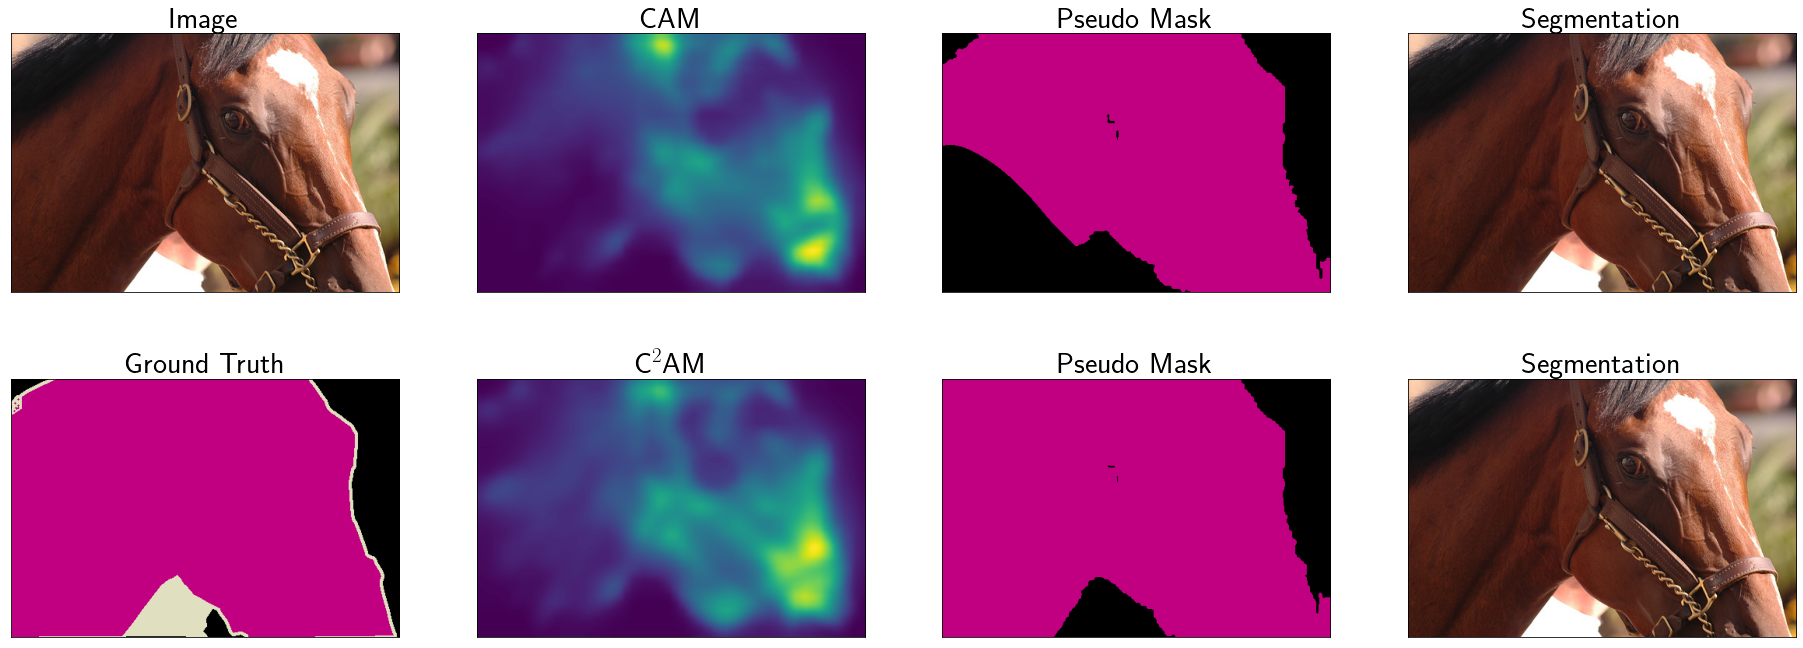

In [16]:
# obj_cat = 'train'
# index = CAT_LIST.index(obj_cat)

img_name = '2008_004430'
plot(img_name)

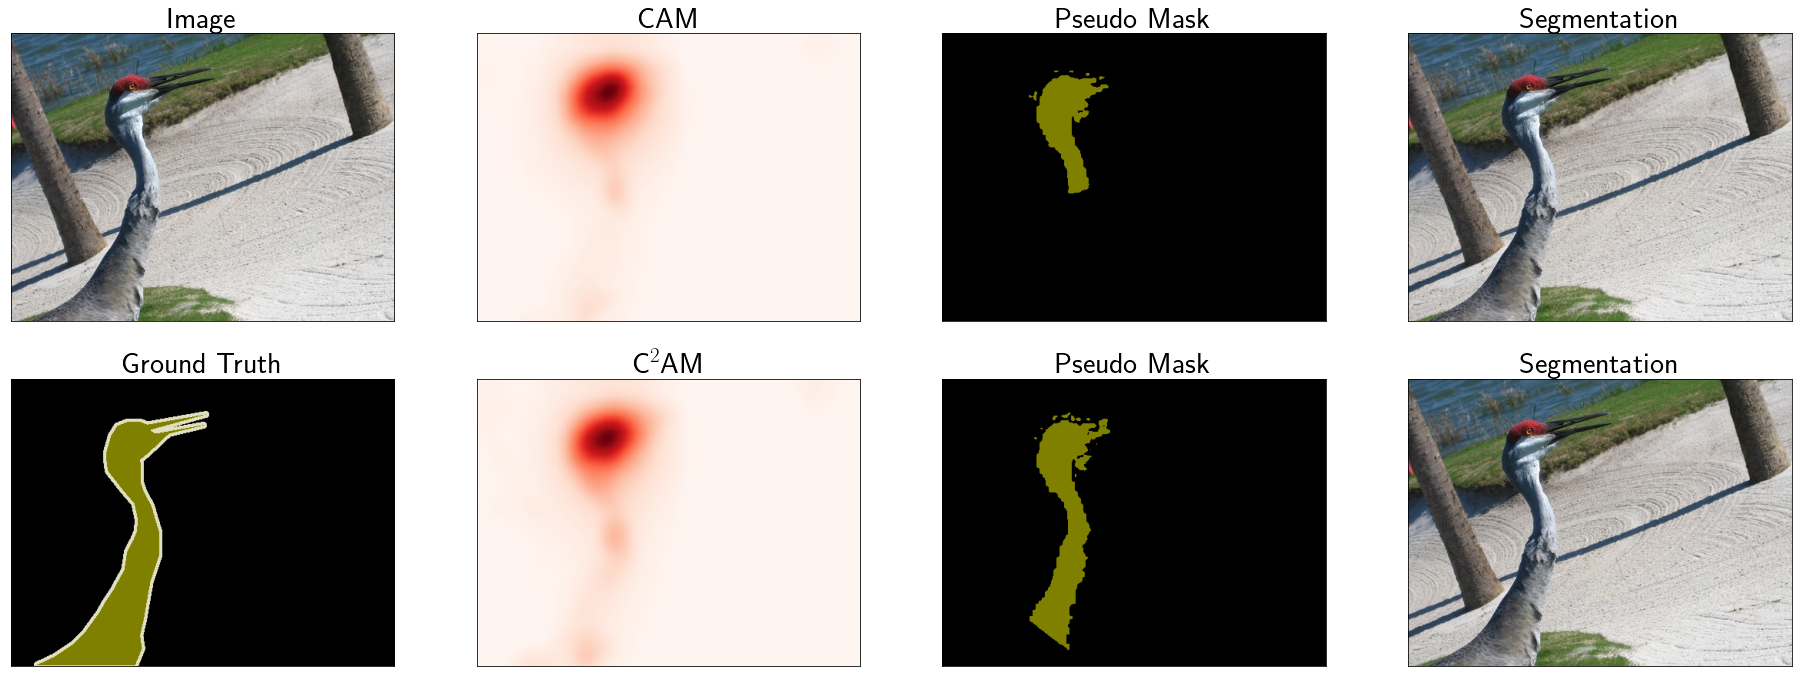

In [12]:
img_name = '2007_000068'
plot(img_name)

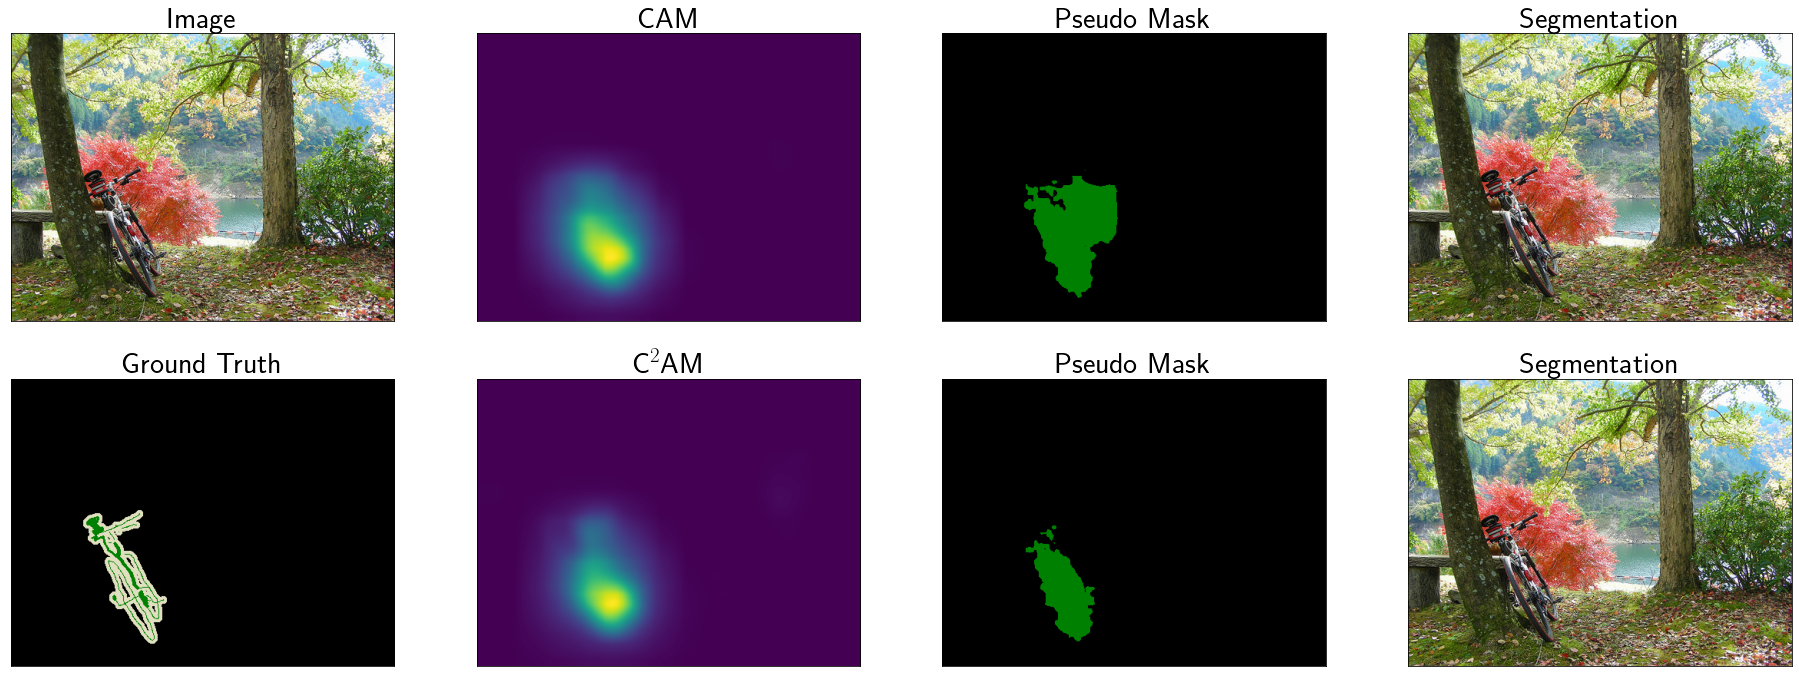

In [46]:
img_name = '2009_000015'
plot(img_name)

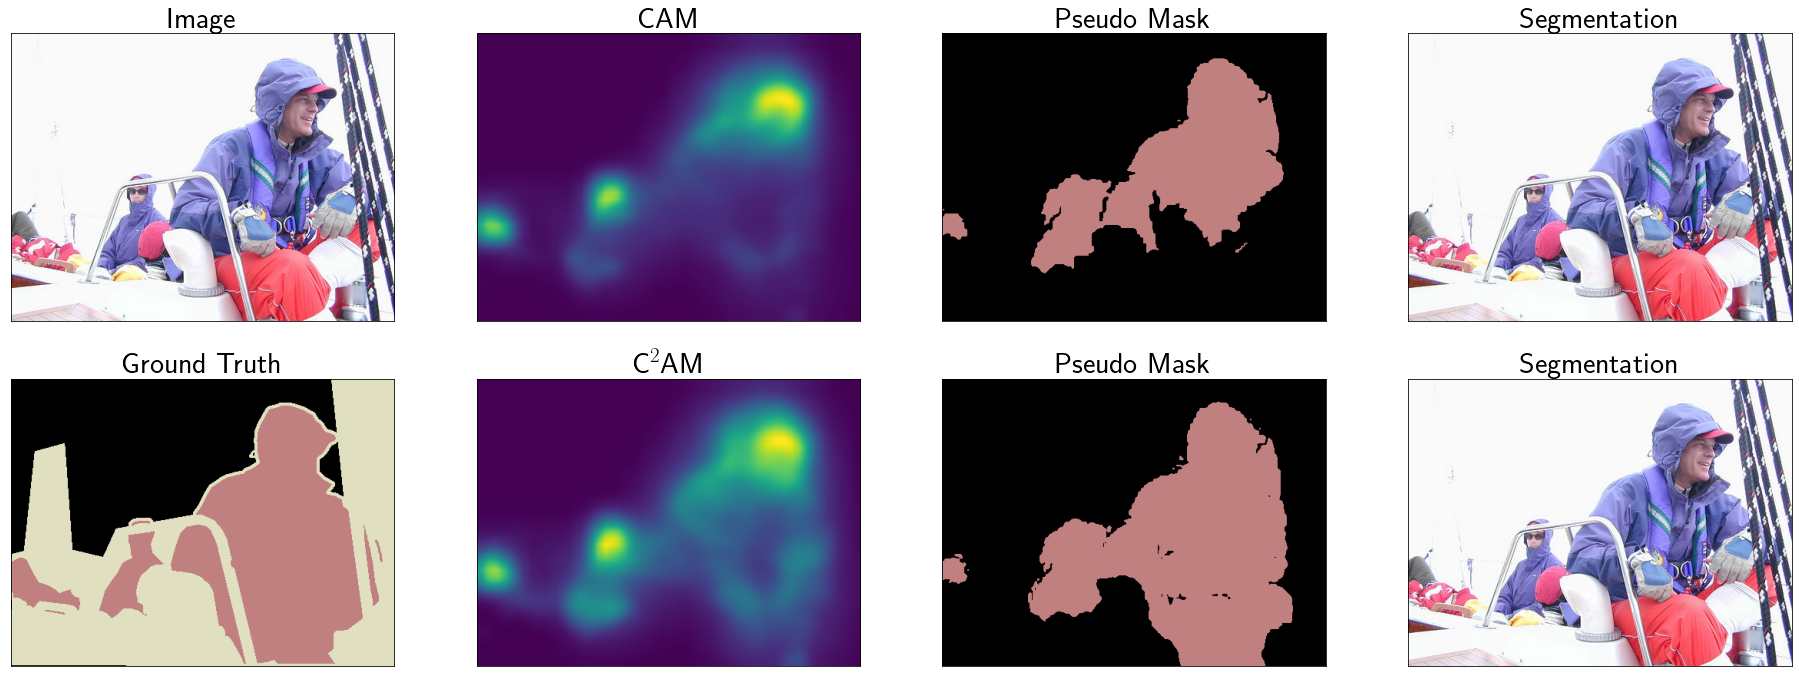

In [47]:
img_name = '2008_003779'
plot(img_name)

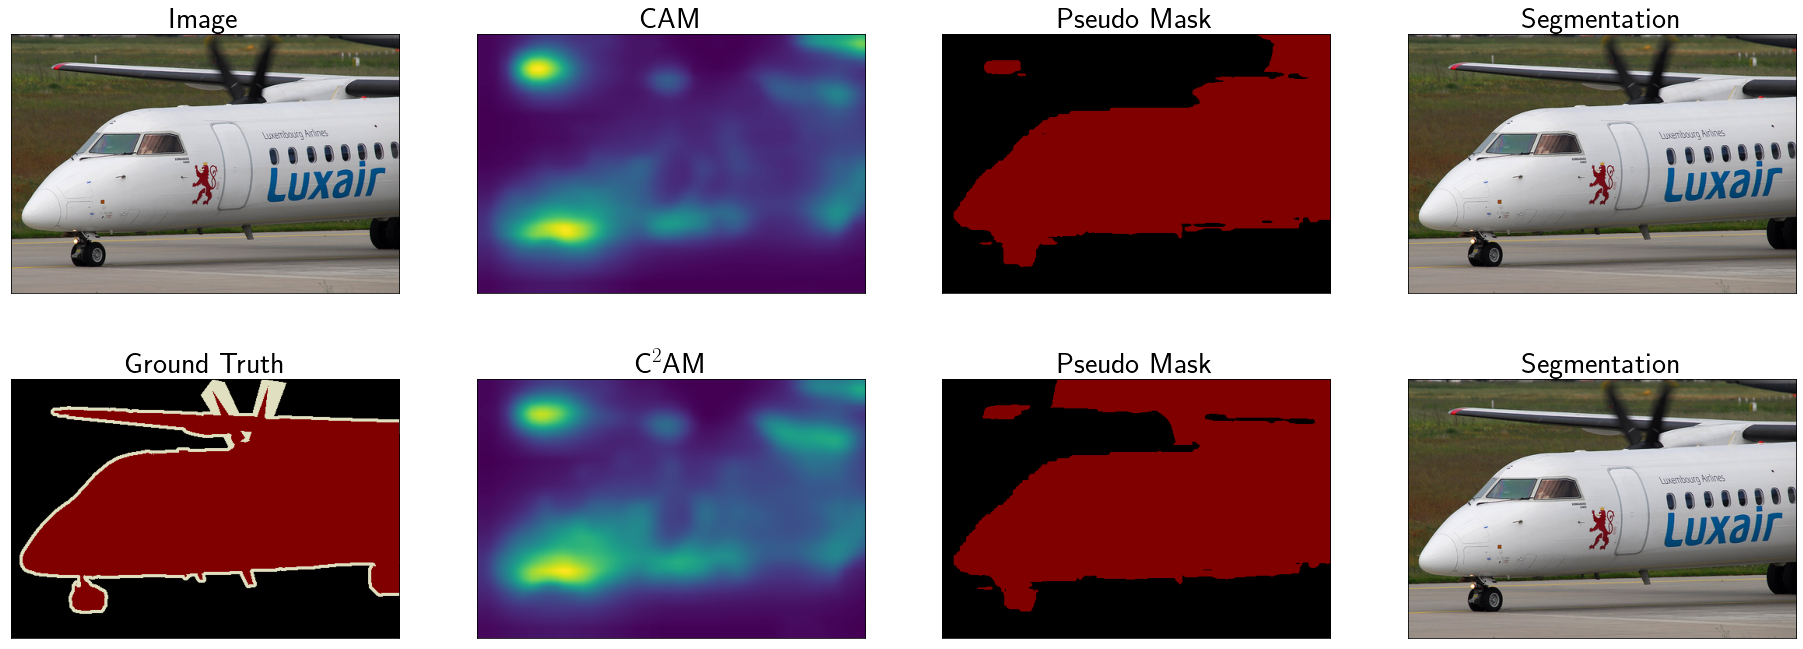

In [48]:
img_name = '2009_000887'
plot(img_name)

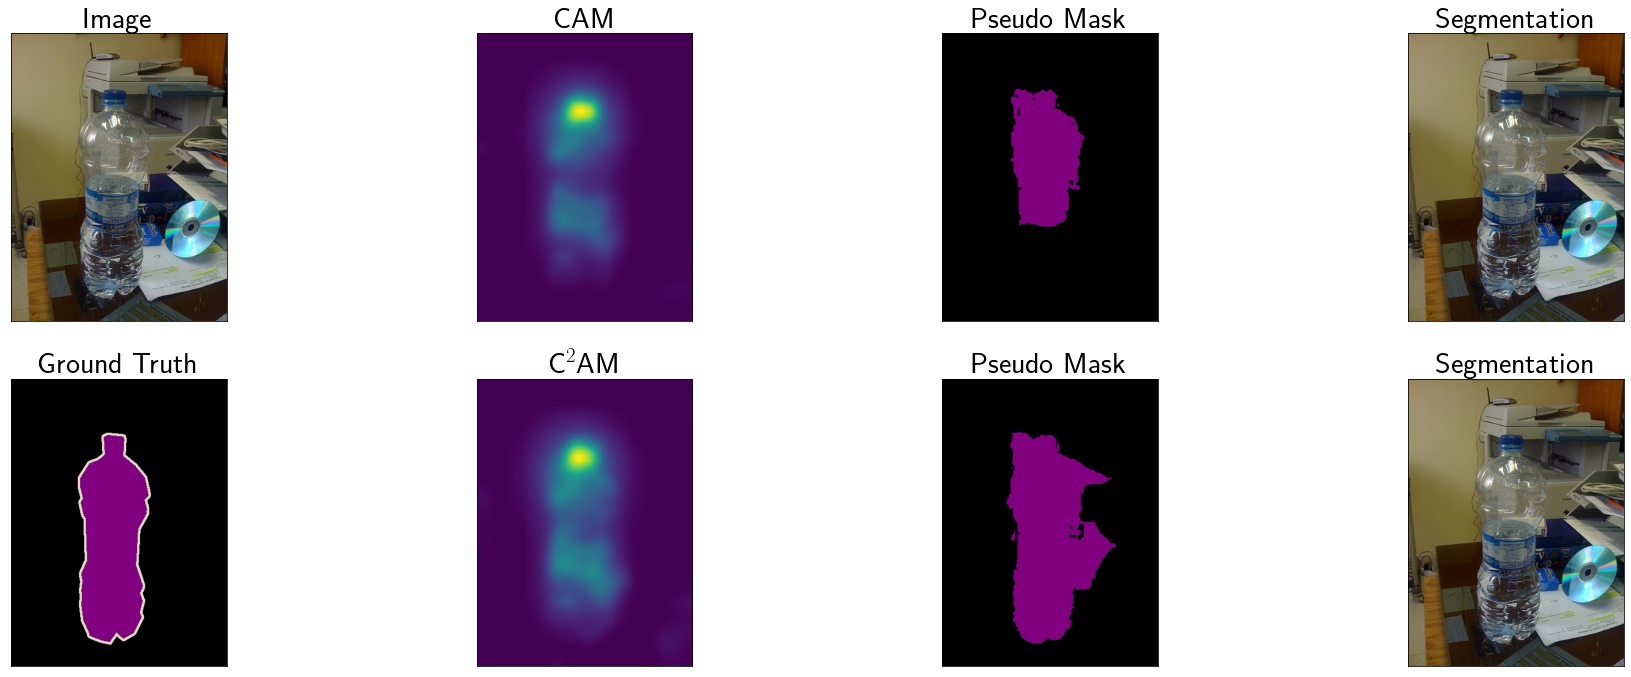

In [49]:
img_name = '2009_001625'
plot(img_name)

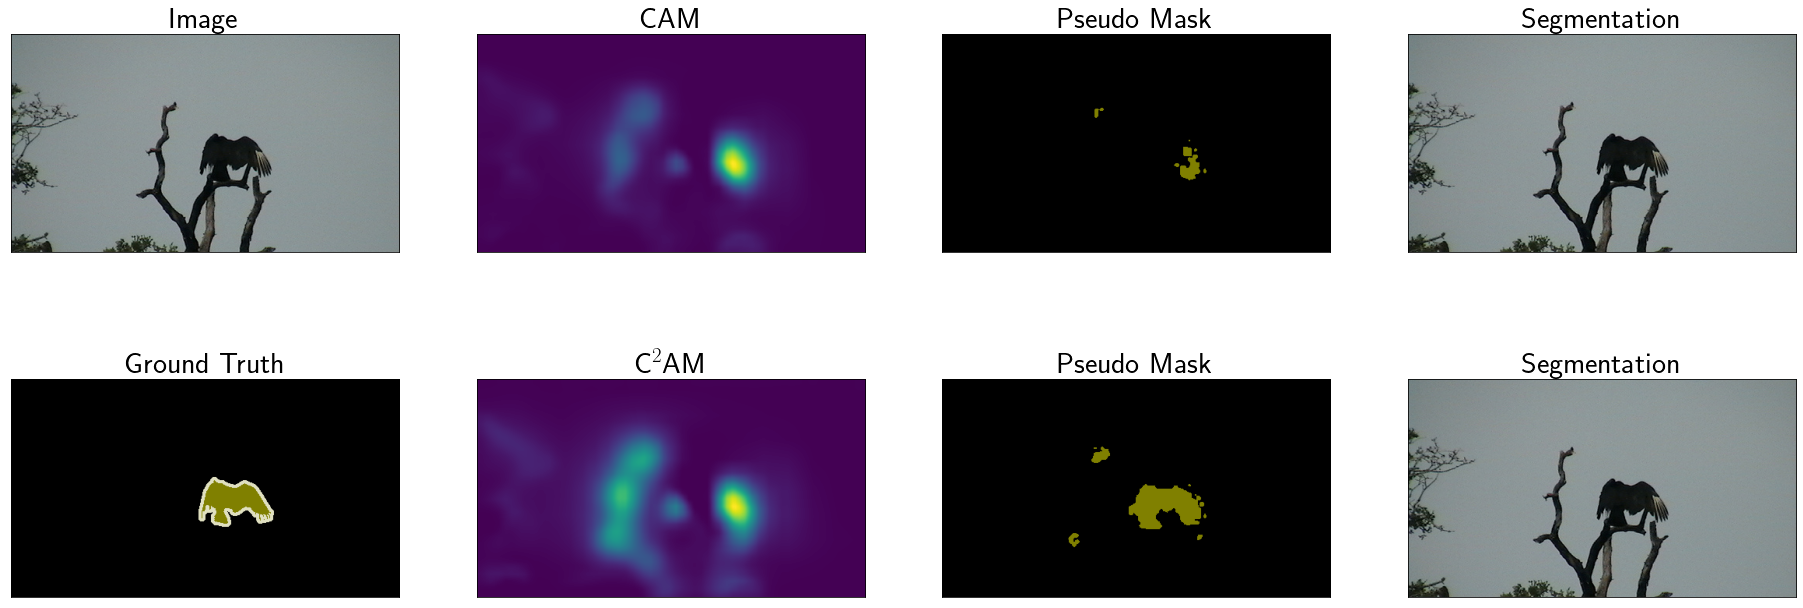

In [53]:
img_name = lowest_name[2]
plot(img_name)

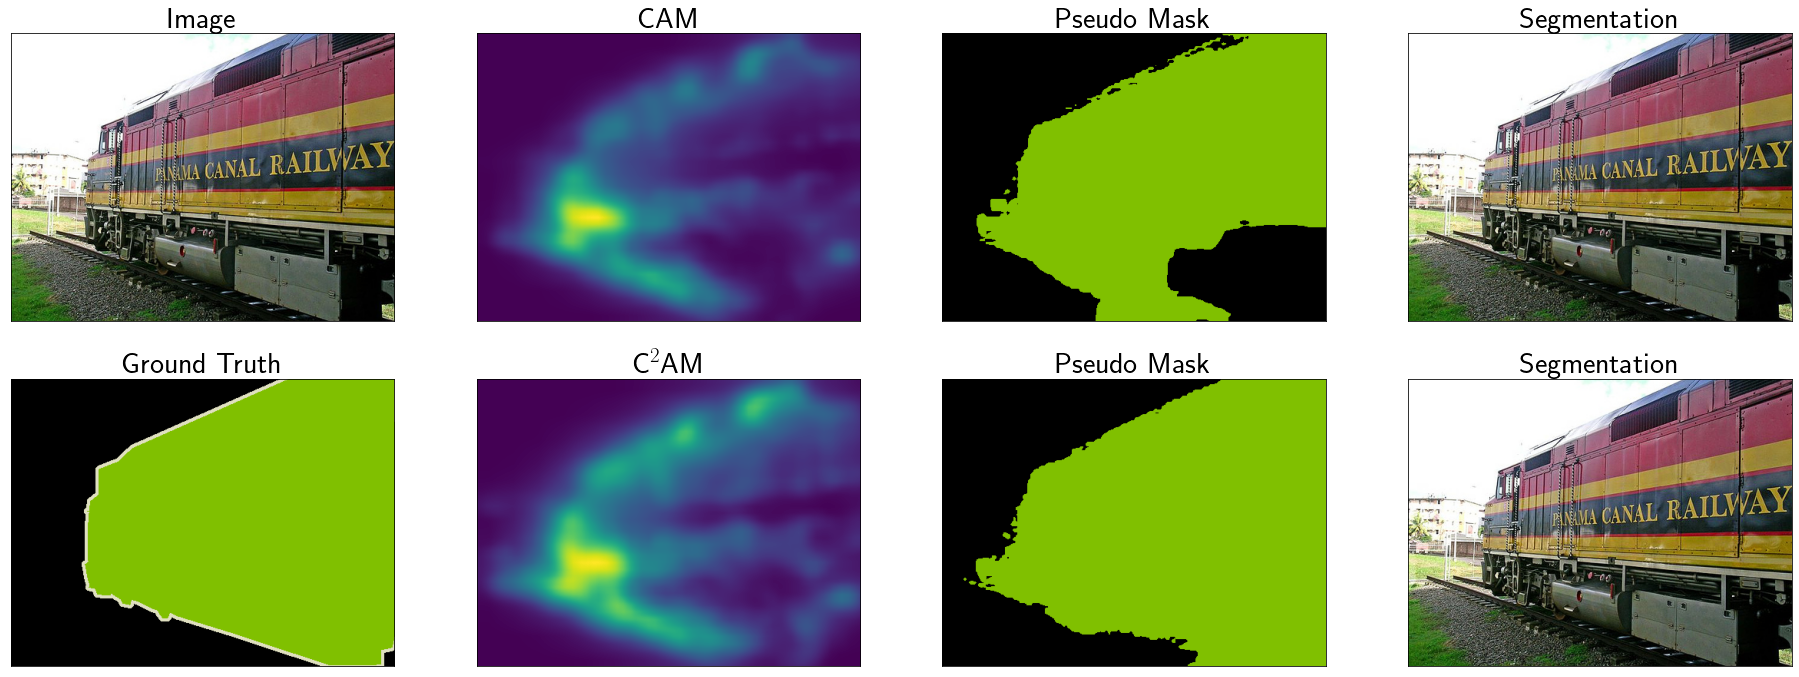

In [67]:
img_name = highest_diff_names[18]
plot(img_name)

# Failure case

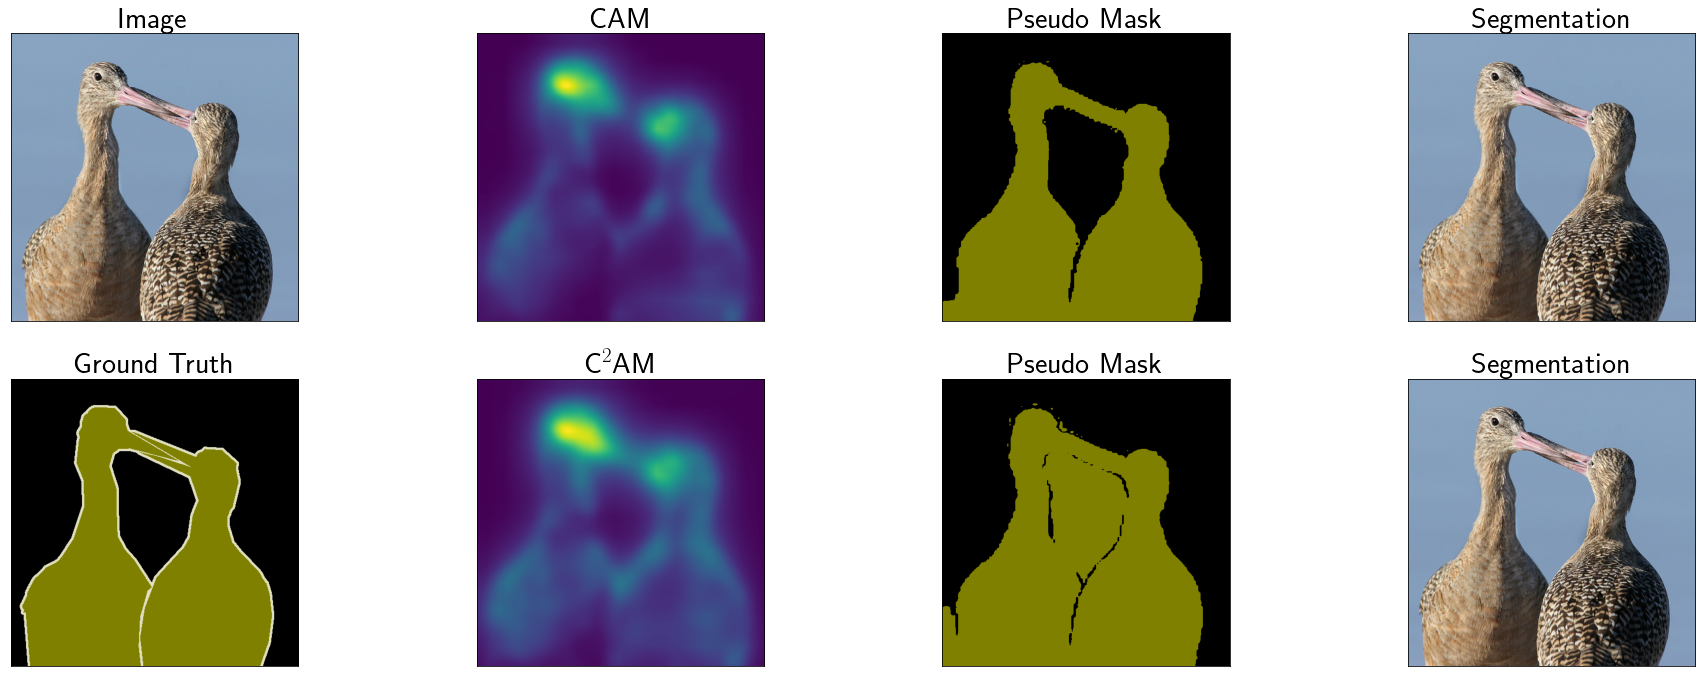

In [50]:
img_name = '2007_005264'
plot(img_name)

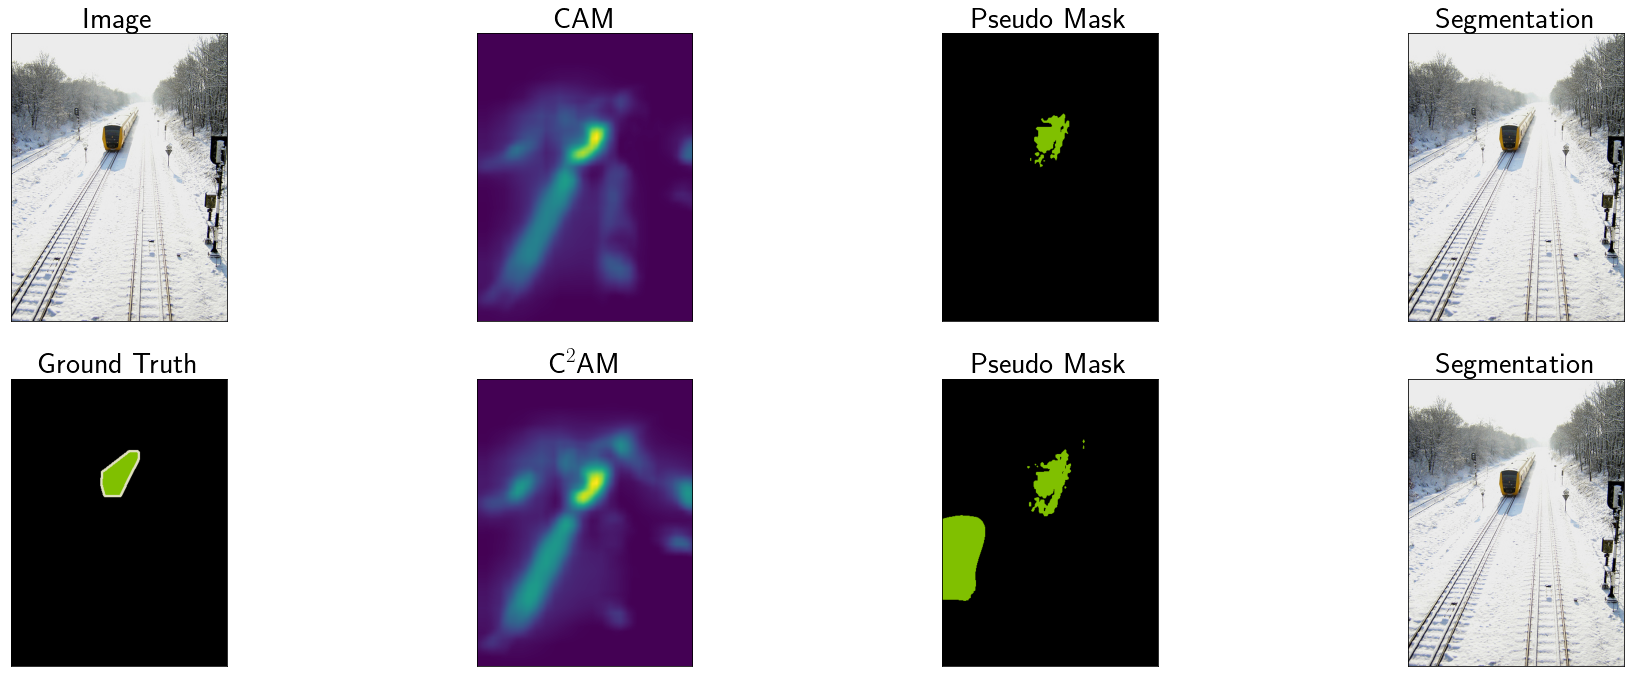

In [51]:
img_name = lowest_name[18]
plot(img_name)

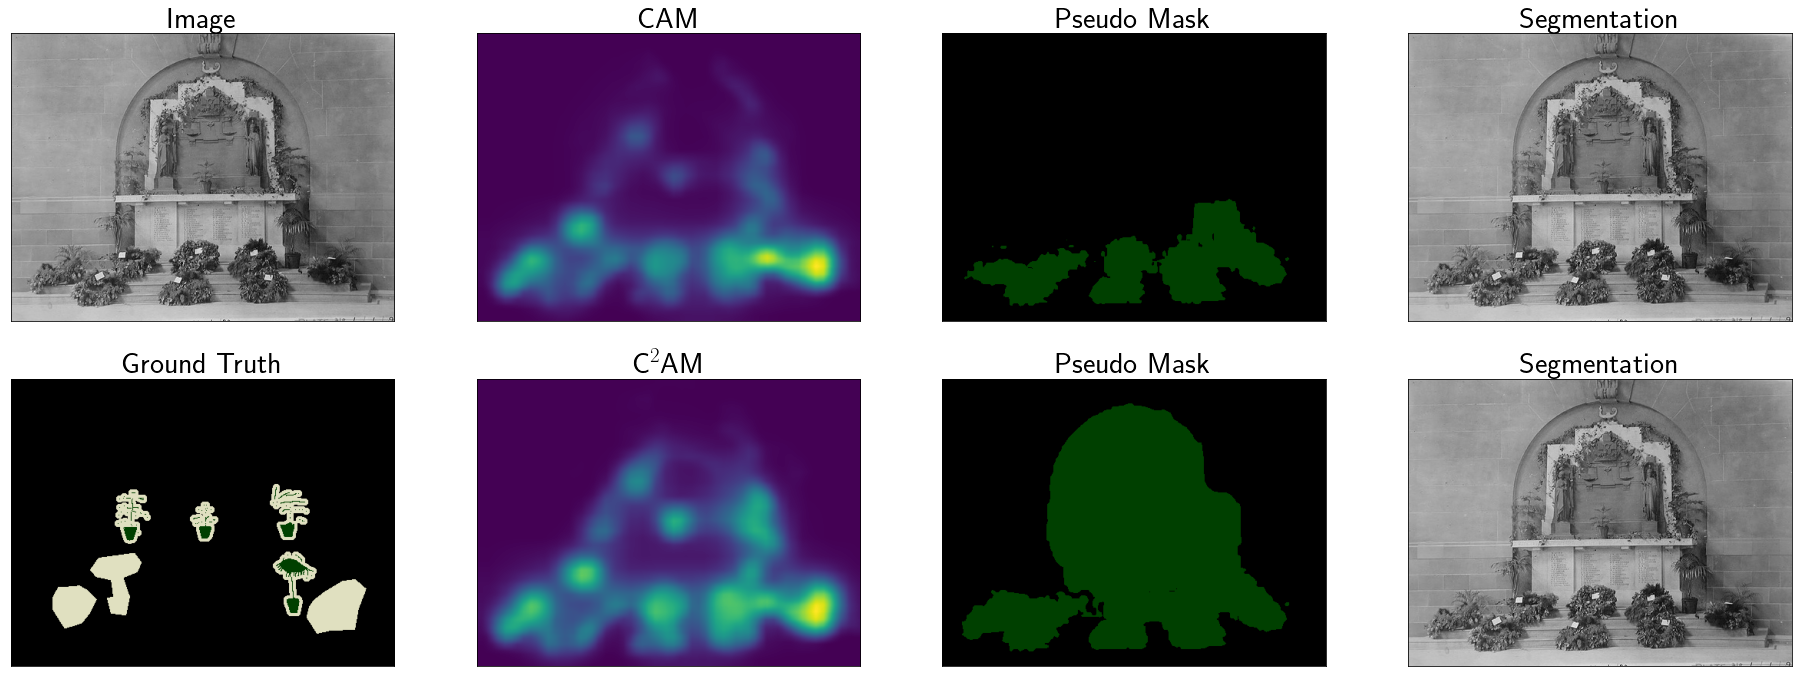

In [52]:
img_name = '2011_002350'
plot(img_name)

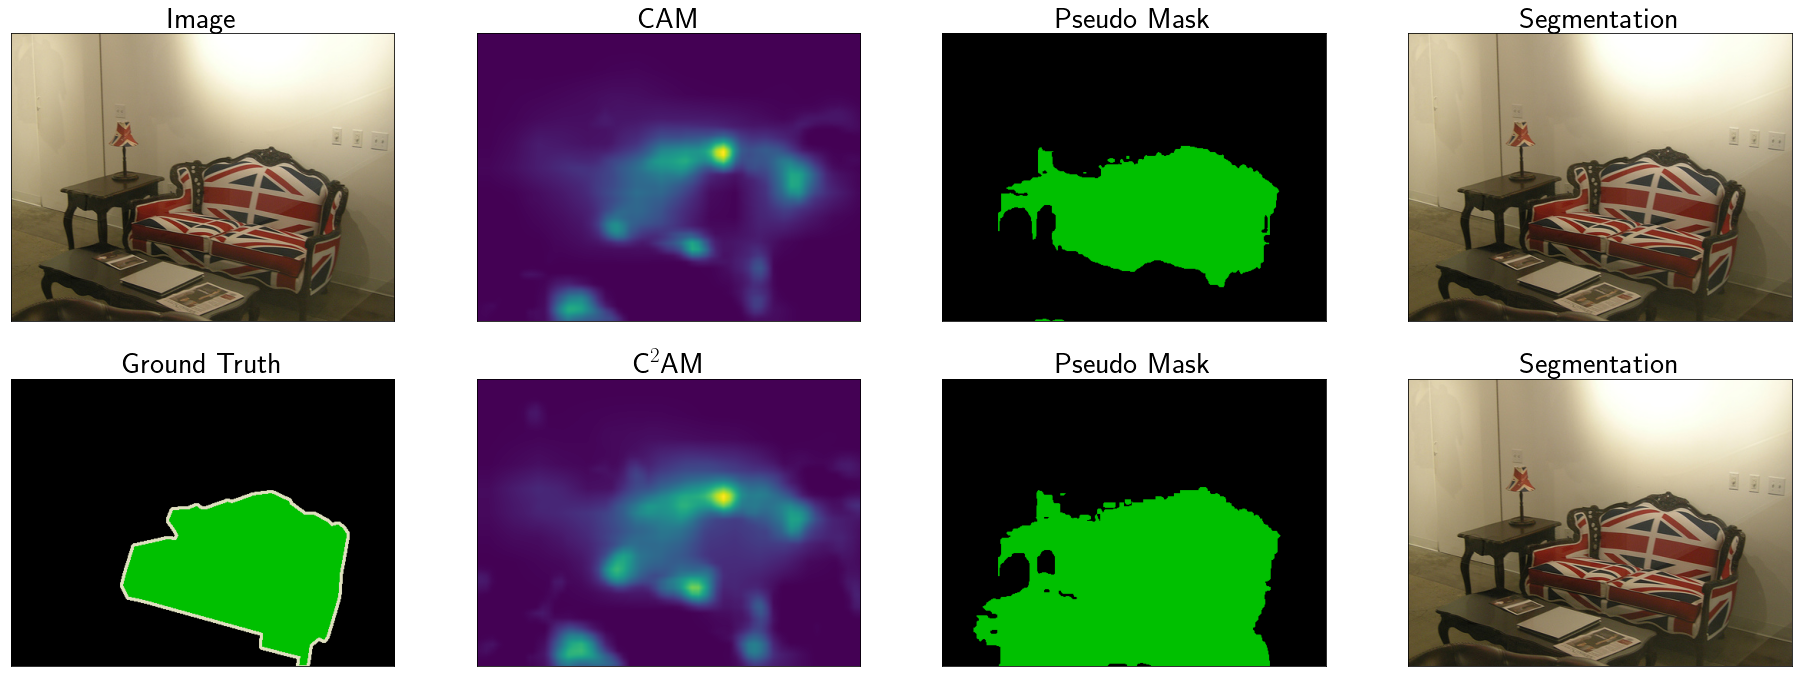

In [68]:
img_name = highest_diff_names[17]
plot(img_name)